In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import talib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional

import time
import boto3
import pandas as pd

ONE_GB_IN_BYTES = 1073741824

# Load the interval of 30 Seconds data from AWS TimeStream Database

In [2]:
session = boto3.Session()
query_client = session.client('timestream-query')

In [3]:
class QueryExample:

    def __init__(self, client):
        self.client = client
        self.paginator = client.get_paginator('query')

    

    def run_all_queries(self):
        for query_id in range(len(self.queries)):
            print("Running query [%d] : [%s]" % (query_id + 1, self.queries[query_id]))
            self.run_query(self.queries[query_id])

    def run_query(self, query_string):
        try:
            page_iterator = self.paginator.paginate(QueryString=query_string)

            for page in page_iterator:
                result_df = self._parse_query_result(page)
        except Exception as err:
            print("Exception while running query:", err)
        
        return result_df

    def _parse_query_result(self, query_result):
        query_status = query_result["QueryStatus"]

        progress_percentage = query_status["ProgressPercentage"]
        print(f"Query progress so far: {progress_percentage}%")

        bytes_scanned = float(query_status["CumulativeBytesScanned"]) / ONE_GB_IN_BYTES
        print(f"Data scanned so far: {bytes_scanned} GB")

        bytes_metered = float(query_status["CumulativeBytesMetered"]) / ONE_GB_IN_BYTES
        print(f"Data metered so far: {bytes_metered} GB")

        column_info = query_result['ColumnInfo']

        print("Metadata: %s" % column_info)
        print("Data: ")
        
        data_arr = []
        for row in query_result['Rows']:
            parsed = self._parse_row(column_info, row)
            data_arr.append(row['Data'])
            print(parsed)
        
        a_df = self._to_pandas_df(data_arr)
        #print(a_df)
        return a_df
    
    def _to_pandas_df(self, arr):
        x_arr = []
        for x in arr:
            i_arr = []
            for i in x:
                i_arr.append(i['ScalarValue'])
            x_arr.append(i_arr)

        return pd.DataFrame(x_arr, columns=['symbol', 'close', 'avg_close', 'min_close', 'max_close', 'binned_timestamp'])

    def _parse_row(self, column_info, row):
        data = row['Data']
        row_output = []
        for j in range(len(data)):
            info = column_info[j]
            datum = data[j]
            row_output.append(self._parse_datum(info, datum))

        return "{%s}" % str(row_output)

    def _parse_datum(self, info, datum):
        if datum.get('NullValue', False):
            return "%s=NULL" % info['Name'],

        column_type = info['Type']

        # If the column is of TimeSeries Type
        if 'TimeSeriesMeasureValueColumnInfo' in column_type:
            return self._parse_time_series(info, datum)

        # If the column is of Array Type
        elif 'ArrayColumnInfo' in column_type:
            array_values = datum['ArrayValue']
            return "%s=%s" % (info['Name'], self._parse_array(info['Type']['ArrayColumnInfo'], array_values))

        # If the column is of Row Type
        elif 'RowColumnInfo' in column_type:
            row_column_info = info['Type']['RowColumnInfo']
            row_values = datum['RowValue']
            return self._parse_row(row_column_info, row_values)

        # If the column is of Scalar Type
        else:
            return self._parse_column_name(info) + datum['ScalarValue']

    def _parse_time_series(self, info, datum):
        time_series_output = []
        for data_point in datum['TimeSeriesValue']:
            time_series_output.append("{time=%s, value=%s}"
                                      % (data_point['Time'],
                                         self._parse_datum(info['Type']['TimeSeriesMeasureValueColumnInfo'],
                                                           data_point['Value'])))
        return "[%s]" % str(time_series_output)

    def _parse_array(self, array_column_info, array_values):
        array_output = []
        for datum in array_values:
            array_output.append(self._parse_datum(array_column_info, datum))

        return "[%s]" % str(array_output)

    def run_query_with_multiple_pages(self, limit):
        query_with_limit = self.SELECT_ALL + " LIMIT " + str(limit)
        print("Starting query with multiple pages : " + query_with_limit)
        self.run_query(query_with_limit)

    def cancel_query(self):
        print("Starting query: " + self.SELECT_ALL)
        result = self.client.query(QueryString=self.SELECT_ALL)
        print("Cancelling query: " + self.SELECT_ALL)
        try:
            self.client.cancel_query(QueryId=result['QueryId'])
            print("Query has been successfully cancelled")
        except Exception as err:
            print("Cancelling query failed:", err)

    @staticmethod
    def _parse_column_name(info):
        if 'Name' in info:
            return info['Name'] + "="
        else:
            return ""

In [4]:
QUERY_1 = f"""
        SELECT
            symbol, measure_name,
            ROUND(AVG(measure_value::double), 2) AS avg_close,
            ROUND(min(measure_value::double), 2) as min_close,
            ROUND(max(measure_value::double), 2) as max_close,
            BIN(time, 30s) AS binned_timestamp
        FROM "realTimeDB"."indexTable"
        where "symbol" = 'OANDA:NAS100_USD' 
        and "measure_name" = 'close'
        GROUP BY symbol, measure_name, BIN(time, 30s)
        ORDER BY binned_timestamp ASC
        """

# Load Data

In [5]:
query_example = QueryExample(query_client)
nasdaq_df = query_example.run_query(QUERY_1)

Query progress so far: 100.0%
Data scanned so far: 8.485931903123856e-05 GB
Data metered so far: 0.009313225746154785 GB
Metadata: [{'Name': 'symbol', 'Type': {'ScalarType': 'VARCHAR'}}, {'Name': 'measure_name', 'Type': {'ScalarType': 'VARCHAR'}}, {'Name': 'avg_close', 'Type': {'ScalarType': 'DOUBLE'}}, {'Name': 'min_close', 'Type': {'ScalarType': 'DOUBLE'}}, {'Name': 'max_close', 'Type': {'ScalarType': 'DOUBLE'}}, {'Name': 'binned_timestamp', 'Type': {'ScalarType': 'TIMESTAMP'}}]
Data: 
{['symbol=OANDA:NAS100_USD', 'measure_name=close', 'avg_close=13771.99', 'min_close=13771.99', 'max_close=13771.99', 'binned_timestamp=2022-04-22 12:31:30.000000000']}
{['symbol=OANDA:NAS100_USD', 'measure_name=close', 'avg_close=13769.28', 'min_close=13768.68', 'max_close=13770.02', 'binned_timestamp=2022-04-22 12:32:00.000000000']}
{['symbol=OANDA:NAS100_USD', 'measure_name=close', 'avg_close=13764.83', 'min_close=13763.59', 'max_close=13766.07', 'binned_timestamp=2022-04-22 12:32:30.000000000']}
{['

In [6]:
nasdaq_df_copy = nasdaq_df.copy()
nasdaq_df_copy['TDate'] = pd.to_datetime(nasdaq_df_copy.binned_timestamp)
nasdaq_df_copy['TDate'] +=  pd.to_timedelta(-4, unit='h')
nasdaq_df_copy.iloc[7:,:]

,symbol,close,avg_close,min_close,max_close,binned_timestamp,TDate
7,OANDA:NAS100_USD,close,13723.54,13721.74,13725.33,2022-04-22 13:30:00.000000000,2022-04-22 09:30:00
8,OANDA:NAS100_USD,close,13732.25,13726.3,13736.14,2022-04-22 13:30:30.000000000,2022-04-22 09:30:30
9,OANDA:NAS100_USD,close,13743.06,13741.28,13744.14,2022-04-22 13:31:00.000000000,2022-04-22 09:31:00
10,OANDA:NAS100_USD,close,13739.48,13735.38,13744.83,2022-04-22 13:31:30.000000000,2022-04-22 09:31:30
11,OANDA:NAS100_USD,close,13729.28,13718.53,13739.44,2022-04-22 13:32:00.000000000,2022-04-22 09:32:00
...,...,...,...,...,...,...,...
763,OANDA:NAS100_USD,close,13373.03,13369.89,13375.69,2022-04-22 19:57:30.000000000,2022-04-22 15:57:30
764,OANDA:NAS100_USD,close,13371.32,13367.07,13373.57,2022-04-22 19:58:00.000000000,2022-04-22 15:58:00
765,OANDA:NAS100_USD,close,13367.0,13365.5,13368.02,2022-04-22 19:58:30.000000000,2022-04-22 15:58:30
766,OANDA:NAS100_USD,close,13357.3,13353.16,13361.01,2022-04-22 19:59:00.000000000,2022-04-22 15:59:00


In [7]:
nasdaq_data_df = nasdaq_df_copy.iloc[7:,:]
nasdaq_data_df = nasdaq_data_df[['avg_close', 'min_close', 'max_close', 'TDate']]
nasdaq_data_df.rename(columns={'avg_close':'close', 'min_close':'low', 'max_close':'high', 'TDate':'trade_date'}, inplace = True)
nasdaq_data_df.head(3)

,close,low,high,trade_date
7,13723.54,13721.74,13725.33,2022-04-22 09:30:00
8,13732.25,13726.3,13736.14,2022-04-22 09:30:30
9,13743.06,13741.28,13744.14,2022-04-22 09:31:00


# Selected Technical Indicators 

- n: For example n = 10

- 1. Simple n-day moving average = (𝐶t + ... 𝐶t-n+1) / n
- 2. Weighted n-day moving average = (𝑛∗𝐶𝑡+(𝑛−1)∗𝐶𝑡−1+⋯+𝐶𝑡−𝑛+1) / (𝑛+(𝑛−1)+⋯+1)
- 3. Relative strength index (RSI) = https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi
- 4. Commodity Channel Index = https://school.stockcharts.com/doku.php?id=technical_indicators:commodity_channel_index_cci
- 5. Rate of Change (ROC) = https://school.stockcharts.com/doku.php?id=technical_indicators:rate_of_change_roc_and_momentum
- 6. Bollinger Bands = https://school.stockcharts.com/doku.php?id=technical_indicators:bollinger_bands
- 7. Momentum = 𝐶𝑡 − 𝐶𝑡−𝑛+1

𝐶𝑡 is the closing price at time t

open(t) is the opening price at time t

v(t) is the volume at time t

In [8]:
# Simple Moving Average
# https://school.stockcharts.com/doku.php?id=technical_indicators:moving_averages
def SMA(data, ndays):
    SMA = pd.Series(data['close'].rolling(ndays, min_periods = 1).mean(), name = 'sma_' + str(ndays))
    data = data.join(SMA)
    return data

# Weighted n-day moving average
def WMA(data, ndays):
    name = 'wma_' + str(ndays)
    data[name] = talib.RSI(data['close'], timeperiod=ndays)
    return data

# Relative strength index (RSI)
def RSI(data, ndays):
    name = 'rsi_' + str(ndays)
    data[name] = talib.RSI(data['close'], timeperiod=ndays)
    return data


# Commodity Channel Index
def CCI(data, ndays):
    name = 'cci_' + str(ndays)
    data[name] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=ndays)
    return data

# Rate of Change (ROC)
def ROC(data, ndays):
    name = 'roc_' + str(ndays)
    data[name] = talib.ROC(data['close'], timeperiod=ndays)
    return data

# Bollinger Bands
def BollingerBands(data, ndays, col_name='close'):
    MA = data[col_name].rolling(ndays, min_periods = 1).mean()
    SD = data[col_name].rolling(ndays, min_periods = 1).std()
    
    b1 = MA + (2 * SD)
    B1 = pd.Series(b1, name = 'bband_upper_' + str(ndays))
    data = data.join(B1)
    
    b2 = MA - (2 * SD)
    B2 = pd.Series(b2, name = 'bband_lower_' + str(ndays))
    data = data.join(B2) 
    return data

def Momentum(data, ndays):
    name = 'mom_' + str(ndays)
    data[name] = talib.MOM(data['close'], timeperiod=ndays)
    return data


def add_indicators(data, ndays = 10):
    data = SMA(data, ndays)
    data = WMA(data, ndays)
    data = RSI(data, ndays)
    data = CCI(data, ndays)
    data = ROC(data, ndays)
    data = BollingerBands(data, ndays)
    data = Momentum(data, ndays)
    
    return data

In [9]:
def indicator_names(ndays):
    arr = ['trade_date', 'close', 'high', 'low',
           'sma_' + str(ndays), 'wma_' + str(ndays), 'rsi_' + str(ndays),
           'cci_' + str(ndays), 'roc_' + str(ndays), 
           'bband_upper_' + str(ndays), 'bband_lower_' + str(ndays), 'mom_' + str(ndays)]

    return arr
    
def get_model_df(data, ndays):
    df_ = add_indicators(data, ndays)
    df_ = df_.iloc[ndays:, :]
    print(df_.shape)
    return df_[indicator_names(ndays)]

In [10]:
get_model_df(nasdaq_data_df, 10)

(751, 12)


,trade_date,close,high,low,sma_10,wma_10,rsi_10,cci_10,roc_10,bband_upper_10,bband_lower_10,mom_10
17,2022-04-22 09:35:00,13750.91,13750.91,13750.91,13747.149,63.494724,63.494724,19.560557,0.199438,13779.248389,13715.049611,27.37
18,2022-04-22 09:45:00,13650.02,13664.79,13642.41,13738.926,30.157838,30.157838,-261.648443,-0.598809,13808.381724,13669.470276,-82.23
19,2022-04-22 09:45:30,13675.27,13681.75,13668.1,13732.147,39.055800,39.055800,-129.545869,-0.493267,13812.229367,13652.064633,-67.79
20,2022-04-22 09:46:00,13658.9,13670.55,13652.44,13724.089,35.772802,35.772802,-114.824612,-0.586485,13816.204155,13631.973845,-80.58
21,2022-04-22 09:46:30,13659.11,13668.07,13654.37,13717.072,35.849664,35.849664,-85.788119,-0.511097,13817.724637,13616.419363,-70.17
...,...,...,...,...,...,...,...,...,...,...,...,...
763,2022-04-22 15:57:30,13373.03,13375.69,13369.89,13382.043,31.498810,31.498810,-86.782808,-0.016149,13399.235352,13364.850648,-2.16
764,2022-04-22 15:58:00,13371.32,13373.57,13367.07,13379.895,30.481280,30.481280,-98.787773,-0.160385,13396.470468,13363.319532,-21.48
765,2022-04-22 15:58:30,13367.0,13368.02,13365.5,13377.386,27.947112,27.947112,-126.315789,-0.187349,13393.341369,13361.430631,-25.09
766,2022-04-22 15:59:00,13357.3,13361.01,13353.16,13373.515,23.146167,23.146167,-194.575699,-0.288967,13388.113914,13358.916086,-38.71


# Train and Evaluate Models

In [11]:
ndays_arr = [10, 20, 50, 100]
back_look_arr = [10, 20, 50, 100]
    
def train_1hidden_LSTM_model(x_train, y_train):
    """
    Simple LSTM with 1 hidden LSTM layers
    """
    #model = Sequential()
    #model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    #model.add(Dense(1))
    #model.compile(optimizer='adam', loss='mse')
    
    # LSTM
    model = Sequential()
    # input_shape=(timesteps, data_dim)
    model.add(LSTM(128, return_sequences=False, input_shape= (x_train.shape[1], x_train.shape[2])))
    #model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1))
    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # train the model
    model.fit(x_train, y_train, batch_size=1, epochs=3)
    
    return model

def train_2hidden_LSTM_model(x_train, y_train):
    """
    Stacked LSTM with 2 hidden LSTM layers
    """
    
    # LSTM
    model = Sequential()
    # input_shape=(timesteps, data_dim)
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # train the model
    model.fit(x_train, y_train, batch_size=1, epochs=3)
    
    return model

def train_bidirectional_LSTM_model(x_train, y_train):
    """
    Bidirectional LSTM
    """
    
    # LSTM
    model = Sequential()
    # input_shape=(timesteps, data_dim)
    model.add(Bidirectional(LSTM(50), input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # train the model
    model.fit(x_train, y_train, batch_size=1, epochs=3)
    
    return model

def forecost_LSTM_model(model, x_valid, y_valid, train_unscaled, valid_unscaled):

    # forecast stock price
    closing_price = model.predict(x_valid)
    
    # Scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(pd.DataFrame(valid_unscaled['close'].values))
    
    # inverse scaler
    closing_price = scaler.inverse_transform(closing_price)
    y_valid = scaler.inverse_transform([y_valid])
    # print(y_valid)
    # print(closing_price)
    
    # get RMSE
    rmse = np.sqrt(np.mean(np.power((y_valid - closing_price), 2)))
    print("rmse = {}".format(str(rmse)))
    
    # get earn_pct
    earn_pct = cal_earn_pct(y_valid, closing_price)
    print("earn_pct = {}".format(str(earn_pct)))
    
    predict_dict_data = {
        'Predictions': closing_price.reshape(1,-1)[0],
        'Close': y_valid[0]
    }
    return rmse, predict_dict_data, earn_pct

# real_closes is np.array, predicted_closes is np.array
def cal_earn_pct(real_closes, predicted_closes):
    real_closes_df = pd.DataFrame(real_closes[0], columns=['real_close'])
    p_closes_df = pd.DataFrame(predicted_closes, columns=['close'])
    
    predicted_closes_df = pd.concat([real_closes_df,p_closes_df], axis=1)
    
    start_cash = 1000000
    
    init_cash = 1000000
    hold_number_stocks = 0
    
    symbol = 'income'
    bought = {symbol:'OUT'}
    trade_lst = []
    sold_lst = []
    # amd_df['direction'] = np.sign(amd_df["close"].pct_change()*100.0)
    # predicted_closes_df = pd.DataFrame([predicted_closes], columns=['close'])
    
    
    predicted_closes_df['predict_direction'] = np.sign(predicted_closes_df["close"].pct_change()*100.0)
    
    for index, row in predicted_closes_df.iterrows():
        
        change_pct = 0.0
        if trade_lst:
            last_one = trade_lst[-1]
            
            change_pct = (row['real_close'] / last_one[0] - 1) * 100
                
        if row['predict_direction'] > 0.0 and bought[symbol] == 'OUT':
            
            trade_lst.append(row)
            
            number_stocks = init_cash // row['real_close']
            hold_number_stocks = number_stocks

            spend = number_stocks * row['real_close']
            #print(init_cash)
            init_cash -= spend


            bought[symbol] = 'LONG'
            continue
            
        elif bought[symbol] == 'LONG' and ( (row['predict_direction'] < 0.0) or change_pct > 1.0 or change_pct < -1.0 ):
            sold_lst.append(row)

            sold = hold_number_stocks * row['real_close']
            #print('sold:' + str(sold))
            #print('init_cash:' + str(init_cash))
            init_cash += sold
            #print('---' + str(init_cash))

            hold_number_stocks = 0
            bought[symbol] = 'OUT'
            continue

    
    cash = init_cash + hold_number_stocks * trade_lst[-1][0]
    print(cash)
    earn_pct = (cash / start_cash - 1) * 100
    print(earn_pct)
    return round(earn_pct, 2)


def split_train_test_sets(amd_df, ndays, back_look_time_steps, training_data_len):
    # back look time steps
    time_stamp = back_look_time_steps

    # get train and test sets
    ind_names = indicator_names(ndays)

    # get features without trade_date
    amd_stock = amd_df[ind_names[1:]]  #  close, sma_10, wma_10, rsi_10

    # un scaled data
    train = amd_stock[0:training_data_len + time_stamp]
    valid = amd_stock[training_data_len - time_stamp:]
    
    train_unscaled = amd_stock[0:training_data_len + time_stamp]
    valid_unscaled = amd_stock[training_data_len - time_stamp:]

    # Scaler
    scaler = MinMaxScaler(feature_range=(0, 1))  
    scaled_data = scaler.fit_transform(train)
    x_train, y_train = [], []


    # train set
    #print(scaled_data.shape)
    #print(scaled_data[1, 0]) # 1 row, close
    for i in range(time_stamp, len(train)):
        x_train.append(scaled_data[i - time_stamp:i])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # valid set
    scaled_data = scaler.fit_transform(valid)
    x_valid, y_valid = [], []
    for i in range(time_stamp, len(valid)):
        x_valid.append(scaled_data[i - time_stamp:i])
        y_valid.append(scaled_data[i, 0])

    x_valid, y_valid = np.array(x_valid), np.array(y_valid)

    #print(x_train.shape)
    #print(x_valid.shape)
    
    return x_train, y_train, x_valid, y_valid, train_unscaled, valid_unscaled
    
def start_2hidden_layers(data_df):
    
    results = []
    
    for ndays in ndays_arr:
        
        # add indicators
        amd_df = get_model_df(data_df, ndays)
        
        # get train set rows
        training_data_len = int(np.ceil( len(amd_df) * .8 ))
        print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))
        
        # use different back_look_steps to train LSTM models
        for back_look_time_steps in back_look_arr:
            
            x_train, y_train, x_valid, y_valid, train_unscaled, valid_unscaled = split_train_test_sets(amd_df, ndays, back_look_time_steps, training_data_len)
            
            print("indicator_ndays = {}, back_look_time_steps = {}. Training start".format(str(ndays), str(back_look_time_steps)))
            
            # train model
            model = train_2hidden_LSTM_model(x_train, y_train)
            
            # forecost
            rmse, predict_dict_data, earn_pct = forecost_LSTM_model(model, x_valid, y_valid, train_unscaled, valid_unscaled)
            
            result_dic = {"model_type":"2_hidden_layers", "indicator_ndays":ndays, "back_look_time_steps":back_look_time_steps, 
                          "rmse":rmse, "earn_pct": earn_pct, "predict_dict_data":predict_dict_data}
            
            results.append(result_dic)
    
    
    return results

def start_1hidden_layers(data_df):
    
    results = []
    
    for ndays in ndays_arr:
        
        # add indicators
        amd_df = get_model_df(data_df, ndays)
        
        # get train set rows
        training_data_len = int(np.ceil( len(amd_df) * .8 ))
        print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))
        
        # use different back_look_steps to train LSTM models
        for back_look_time_steps in back_look_arr:
            
            x_train, y_train, x_valid, y_valid, train_unscaled, valid_unscaled = split_train_test_sets(amd_df, ndays, back_look_time_steps, training_data_len)
            
            print("indicator_ndays = {}, back_look_time_steps = {}. Training start".format(str(ndays), str(back_look_time_steps)))
            
            # train model
            model = train_1hidden_LSTM_model(x_train, y_train)
            
            # forecost
            rmse, predict_dict_data, earn_pct = forecost_LSTM_model(model, x_valid, y_valid, train_unscaled, valid_unscaled)
            
            result_dic = {"model_type":"1_hidden_layers", "indicator_ndays":ndays, "back_look_time_steps":back_look_time_steps, 
                          "rmse":rmse, "earn_pct": earn_pct, "predict_dict_data":predict_dict_data}
            
            results.append(result_dic)
    
    
    return results


def start_bidirectional_LSTM(data_df):
    
    results = []
    
    for ndays in ndays_arr:
        
        # add indicators
        amd_df = get_model_df(data_df, ndays)
        
        # get train set rows
        training_data_len = int(np.ceil( len(amd_df) * .8 ))
        print("train_length:{}, test_length:{}".format(training_data_len, len(amd_df) - training_data_len))
        
        # use different back_look_steps to train LSTM models
        for back_look_time_steps in back_look_arr:
            
            x_train, y_train, x_valid, y_valid, train_unscaled, valid_unscaled = split_train_test_sets(amd_df, ndays, back_look_time_steps, training_data_len)
            
            print("indicator_ndays = {}, back_look_time_steps = {}. Training start".format(str(ndays), str(back_look_time_steps)))
            
            # train model
            model = train_bidirectional_LSTM_model(x_train, y_train)
            
            # forecost
            rmse, predict_dict_data, earn_pct = forecost_LSTM_model(model, x_valid, y_valid, train_unscaled, valid_unscaled)
            
            result_dic = {"model_type":"bidirectional_LSTM", "indicator_ndays":ndays, "back_look_time_steps":back_look_time_steps, 
                          "rmse":rmse, "earn_pct": earn_pct, "predict_dict_data":predict_dict_data}
            
            results.append(result_dic)
    
    
    return results


rmse_results_bidirectional = start_bidirectional_LSTM(nasdaq_data_df.copy())
rmse_results1 = start_1hidden_layers(nasdaq_data_df.copy())
rmse_results2 = start_2hidden_layers(nasdaq_data_df.copy())

(751, 12)
train_length:601, test_length:150
indicator_ndays = 10, back_look_time_steps = 10. Training start
Epoch 1/3
601/601 [==============================] - 2s 3ms/step - loss: 0.0029
Epoch 2/3
601/601 [==============================] - 2s 3ms/step - loss: 0.0014
Epoch 3/3
601/601 [==============================] - 2s 3ms/step - loss: 0.0010
rmse = 52.0755252326214
1003376.6499999993
0.3376649999999426
earn_pct = 0.34
indicator_ndays = 10, back_look_time_steps = 20. Training start
Epoch 1/3
601/601 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 2/3
601/601 [==============================] - 3s 4ms/step - loss: 0.0011
Epoch 3/3
601/601 [==============================] - 3s 4ms/step - loss: 0.0012
rmse = 50.98967240004534
1002916.3399999997
0.29163399999996287
earn_pct = 0.29
indicator_ndays = 10, back_look_time_steps = 50. Training start
Epoch 1/3
601/601 [==============================] - 5s 9ms/step - loss: 0.0030
Epoch 2/3
601/601 [===========================

Epoch 1/3
593/593 [==============================] - 2s 3ms/step - loss: 0.0034
Epoch 2/3
593/593 [==============================] - 2s 3ms/step - loss: 9.4034e-04
Epoch 3/3
593/593 [==============================] - 2s 3ms/step - loss: 9.3411e-04
rmse = 52.31112434459503
1001506.6399999999
0.15066399999998925
earn_pct = 0.15
indicator_ndays = 20, back_look_time_steps = 20. Training start
Epoch 1/3
593/593 [==============================] - 3s 5ms/step - loss: 0.0024
Epoch 2/3
593/593 [==============================] - 3s 5ms/step - loss: 9.7689e-04
Epoch 3/3
593/593 [==============================] - 3s 5ms/step - loss: 6.4492e-04
rmse = 51.39503608672891
1001606.5399999999
0.1606539999999823
earn_pct = 0.16
indicator_ndays = 20, back_look_time_steps = 50. Training start
Epoch 1/3
593/593 [==============================] - 7s 11ms/step - loss: 0.0036
Epoch 2/3
593/593 [==============================] - 6s 11ms/step - loss: 6.4571e-04
Epoch 3/3
593/593 [==============================] 

569/569 [==============================] - 3s 6ms/step - loss: 0.0014
Epoch 3/3
569/569 [==============================] - 3s 5ms/step - loss: 0.0013
rmse = 46.523399640921795
1000779.9599999994
0.07799599999993578
earn_pct = 0.08
indicator_ndays = 50, back_look_time_steps = 20. Training start
Epoch 1/3
569/569 [==============================] - 5s 9ms/step - loss: 0.0044
Epoch 2/3
569/569 [==============================] - 6s 10ms/step - loss: 0.0015
Epoch 3/3
569/569 [==============================] - 5s 10ms/step - loss: 9.6086e-04
rmse = 49.06113587294716
1001812.999999999
0.18129999999989543
earn_pct = 0.18
indicator_ndays = 50, back_look_time_steps = 50. Training start
Epoch 1/3
569/569 [==============================] - 9s 17ms/step - loss: 0.0036
Epoch 2/3
569/569 [==============================] - 10s 17ms/step - loss: 0.0015
Epoch 3/3
569/569 [==============================] - 10s 17ms/step - loss: 0.0011
rmse = 49.279675454472354
1001814.4799999994
0.18144799999995076
earn_p

# Show the Results

In [16]:
rmse_df = pd.DataFrame(rmse_results_bidirectional + rmse_results1 + rmse_results2)
rmse_df.iloc[:,:5].sort_values(by=['earn_pct'], ascending=False)

,model_type,indicator_ndays,back_look_time_steps,rmse,earn_pct
4,bidirectional_LSTM,20,10,51.308925,0.42
3,bidirectional_LSTM,10,100,51.960233,0.41
0,bidirectional_LSTM,10,10,52.075525,0.34
38,2_hidden_layers,20,50,51.064519,0.34
35,2_hidden_layers,10,100,52.491135,0.34
32,2_hidden_layers,10,10,51.264515,0.33
33,2_hidden_layers,10,20,48.920471,0.32
37,2_hidden_layers,20,20,52.258542,0.31
16,1_hidden_layers,10,10,51.941157,0.30
1,bidirectional_LSTM,10,20,50.989672,0.29


In [13]:
rmse_df.iloc[:,:5].sort_values(by=['rmse'])

,model_type,indicator_ndays,back_look_time_steps,rmse,earn_pct
10,bidirectional_LSTM,50,50,45.211074,0.11
14,bidirectional_LSTM,100,50,45.574141,0.10
45,2_hidden_layers,100,20,45.937011,0.19
40,2_hidden_layers,50,10,46.523400,0.08
6,bidirectional_LSTM,20,50,46.849175,0.25
12,bidirectional_LSTM,100,10,47.034844,0.14
9,bidirectional_LSTM,50,20,47.093590,0.05
28,1_hidden_layers,100,10,47.488039,0.19
13,bidirectional_LSTM,100,20,47.762298,0.18
46,2_hidden_layers,100,50,48.319627,0.17


# Plot the data with the lowest RMSE

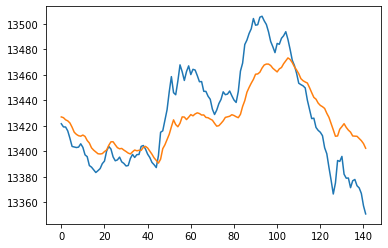

In [14]:
data_pd = pd.DataFrame(rmse_df.sort_values(by=['rmse']).iloc[:1]["predict_dict_data"].values[0])

plt.plot(data_pd[['Close', 'Predictions']])
plt.show()

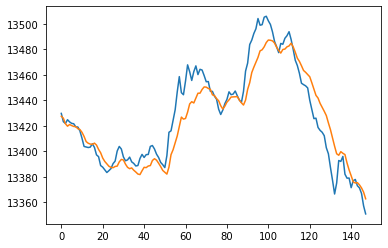

In [17]:
data_pd = pd.DataFrame(rmse_df.sort_values(by=['earn_pct'], ascending=False).iloc[0:1]["predict_dict_data"].values[0])

plt.plot(data_pd[['Close', 'Predictions']])
plt.show()